In [131]:
import pandas as pd
import numpy as np
from stratified_dataset import ParallelStratifiedSynthesizer
from snsynth.mst import MSTSynthesizer
from snsynth.aim import AIMSynthesizer
from gem_synthesizer import GEMSynthesizer
import dill
from data_utils import get_employment
import itertools
import os
from IPython.display import clear_output

all_data, features, target, group = get_employment()

['RELP']


In [76]:
def calculate_dimensionality(df):
    dimensionality = 1
    for col in df.columns:
        unique_values = df[col].nunique()
        dimensionality *= unique_values
    return dimensionality

data_dimensionality = calculate_dimensionality(all_data)
print("Dimensionality of the data:", data_dimensionality)

Dimensionality of the data: 777600000


In [77]:
df = all_data.copy()
df = df.drop(columns=['CIT', 'MIG', 'DEAR', 'DEYE', 'NATIVITY', 'ANC'])

data_dimensionality = calculate_dimensionality(df)
print("Dimensionality of the data:", data_dimensionality)

Dimensionality of the data: 1215000


In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'all_data' dataframe is already defined
df = all_data.copy()

df = df.drop(columns=['CIT', 'MIG', 'DEAR', 'DEYE', 'NATIVITY', 'ANC'])

def train_on_df(df):
    # Target column
    target_col = 'ESR'

    # Feature columns
    feature_cols = [col for col in df.columns if col != target_col]

    # Convert all columns to categorical
    for col in df.columns:
        df[col] = df[col].astype('category')

    # Prepare the dataset
    X = df[feature_cols]
    y = df[target_col]

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Find the most influential features
    importances = clf.feature_importances_
    feature_importances = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)

    print("Feature importances:")
    for feature, importance in feature_importances:
        print(f"{feature}: {importance}")
    
    return acc

accuracy_overall = train_on_df(df)

Accuracy: 0.7938264710361984

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.78      0.80     20971
         1.0       0.76      0.81      0.79     18423

    accuracy                           0.79     39394
   macro avg       0.79      0.80      0.79     39394
weighted avg       0.80      0.79      0.79     39394

Feature importances:
AGEP: 0.43235175354485184
SCHL: 0.23475111645036695
DIS: 0.10102305002883707
MIL: 0.07064120601923872
ESP: 0.046742781409869184
MAR: 0.03916345569503386
DREM: 0.03020780939002446
RAC1P: 0.0256614369739042
SEX: 0.01945739048787377


In [79]:
# TODO: Stratified public synthesizers

# Randomly shuffle the indices of the dataframe
# shuffled_indices = np.random.permutation(df.index)

# Split the shuffled dataframe into two equal parts
# half = len(df) // 2
# public_df = df.iloc[shuffled_indices[half:]]
# df = df.iloc[shuffled_indices[:half]]

In [80]:
# List of column names you want to use
cols = ['SEX', 'RAC1P'] #, 'DIS', 'AGEP']

# Generate all possible combinations of the given column names
combinations = []
for i in range(1, len(cols) + 1):
    combinations.extend(list(itertools.combinations(cols, i)))

In [140]:
# Make models directory if one doesnt exist
if not os.path.exists("models"):
    os.mkdir("models")

# Make log text file
log_filename = "models/log.txt"
log_path = os.path.join(os.getcwd(), log_filename)
if not os.path.exists(log_path):
    with open(log_filename, "w") as file:
        file.write("")

def fit_vanilla_model(model, epsilon, df):
    model_filename = f"models/{model.__name__}_epsilon_{epsilon}.dill"
    
    model_path = os.path.join(os.getcwd(), model_filename)
    if os.path.exists(model_path):
        print(f"Model {model_filename} already exists. Skipping.")
        return
    
    m = model(epsilon=epsilon)
    m.fit(df)
    with open(model_filename, "wb") as file:
        dill.dump(m, file)

synthesizers = [MSTSynthesizer, AIMSynthesizer, GEMSynthesizer] #, MSTSynthesizer, AIMSynthesizer]

# Epsilon values to try
epsilons = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]

for synth_class in synthesizers:
    for epsilon in epsilons:
        print(f"Training vanilla Synthesizer with {synth_class.__name__} and epsilon = {epsilon}")
        try:
            assert True == False
            fit_vanilla_model(MSTSynthesizer, epsilon, df)
        except:
            print(f"Failed to fit vanilla Synthesizer with {synth_class.__name__} with epsilon = {epsilon}")
            # Add to a log that we failed to fit this model
            with open(log_filename, "a") as file:
                file.write(f"Failed to fit vanilla Synthesizer with {synth_class.__name__} with epsilon = {epsilon}\n")

        for combination in list(combinations):
            strata_cols = list(combination)
            
            print(f"Training ParallelStratifiedSynthesizer with {synth_class.__name__} and epsilon = {epsilon}")

            name_combo = str("_".join(combination))
            model_filename = f"models/{synth_class.__name__}_epsilon_{epsilon}_{name_combo}.dill"
            
            # Check if the model file already exists, and if so, skip training and pickling
            model_path = os.path.join(os.getcwd(), model_filename)
            if os.path.exists(model_path):
                print(f"Model {model_filename} already exists. Skipping.")
                continue

            clear_output(wait=True)

            # Split the dataframe into train set
            train_df, _ = train_test_split(df, test_size=0.2, random_state=42)
            try:
                assert True == False
                stratified_synth = ParallelStratifiedSynthesizer(synth_class, epsilon=epsilon)
                stratified_synth.fit(df, strata_cols=strata_cols, categorical_columns=df.columns)

                # Pickle the trained model
                with open(model_filename, "wb") as file:
                    dill.dump(stratified_synth, file)
                
                print(f"Model saved as {model_filename}")
            except:
                print(f"Failed to fit ParallelStratifiedSynthesizer with {synth_class.__name__} with epsilon = {epsilon} and strata_cols = {strata_cols}")
                # Add to a log that we failed to fit this model
                with open(log_filename, "a") as file:
                    file.write(f"Failed to fit ParallelStratifiedSynthesizer with {synth_class.__name__} with epsilon = {epsilon} and strata_cols = {strata_cols}\n")
            
            

print("All models trained and pickled.")

Failed to fit ParallelStratifiedSynthesizer with GEMSynthesizer with epsilon = 5.0 and strata_cols = ['SEX', 'RAC1P']
All models trained and pickled.


In [82]:
def evaluate_on_dataframes(train_df, test_df):
    # Target column
    target_col = 'ESR'

    # Feature columns
    feature_cols = [col for col in train_df.columns if col != target_col]

    # Convert all columns to categorical
    for col in train_df.columns:
        train_df[col] = train_df[col].astype('category')
    
    for col in test_df.columns:
        test_df[col] = test_df[col].astype('category')

    # Prepare the dataset
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    # Train the classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def load_pickled_model(filename):
    with open(filename, "rb") as file:
        model = dill.load(file)
    return model

def plot_performance_synths(performance_df, overall_accuracy):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set(font_scale=1.5)
    # add baseline performance horizontal line at specific y value
    baseline = max(df['ESR'].value_counts() / len(df))
    plt.axhline(y=baseline, color='r', linestyle='--')
    plt.axhline(y=overall_accuracy, color='violet', linestyle='--')
    sns.lineplot(data=performance_df, x='Epsilon', y='Accuracy', hue='Synthesizer')
    plt.xlabel("Epsilon")
    plt.ylabel("Classification accuracy")
    plt.title("Stratified synthesizers with different protected classes \n on the employment prediciton task.")
    plt.xscale('log')
    plt.show()
    
def generate_performance_plots(real_train_df, real_test_df, combinations, synthesizers, epsilons, accuracy_overall):
    # Create an empty DataFrame with the appropriate columns and index
    performance_df = pd.DataFrame(columns=['Synthesizer', 'Epsilon', 'Accuracy'])
    
    for synth_class in synthesizers:
        for epsilon in epsilons:
            model_filename = f"models/{synth_class.__name__}_epsilon_{epsilon}.dill"
            model = load_pickled_model(model_filename)
            synth_df = model.sample(real_train_df.shape[0])

            accuracy = evaluate_on_dataframes(synth_df, real_test_df)
            performance_df = performance_df.append({
                'Synthesizer': synth_class.__name__,
                'Epsilon': epsilon,
                'Accuracy': accuracy
            }, ignore_index=True)

            for combination in combinations:
                name_combo = str("_".join(combination))
                model_filename = f"models/{synth_class.__name__}_epsilon_{epsilon}_{name_combo}.dill"
                model = load_pickled_model(model_filename)
                try:
                    synth_df = model.sample(real_train_df.shape[0])

                    accuracy = evaluate_on_dataframes(synth_df, real_test_df)
                    performance_df = performance_df.append({
                        'Synthesizer': synth_class.__name__ + '_' + name_combo,
                        'Epsilon': epsilon,
                        'Accuracy': accuracy
                    }, ignore_index=True)
                except:
                    print(f"Failed to evaluate {synth_class.__name__} with epsilon = {epsilon} and combination = {name_combo}")
                    performance_df = performance_df.append({
                        'Synthesizer': synth_class.__name__ + '_' + name_combo,
                        'Epsilon': epsilon,
                        'Accuracy': accuracy
                    }, ignore_index=True)
                    continue
    
    # Dill and store the performance dataframe
    performance_df.to_pickle('performance_df.pkl')

    # Create a line plot using seaborn
    plot_performance_synths(performance_df, accuracy_overall)

    return performance_df

In [ ]:
# Prepare the real dataset for evaluation
X_real = df.drop('ESR', axis=1)
y_real = df['ESR']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42)
train_df_real = X_train_real.copy()
train_df_real['ESR'] = y_train_real
test_df_real = X_test_real.copy()
test_df_real['ESR'] = y_test_real

# Generate the performance plots
performance_df = generate_performance_plots(train_df_real, test_df_real, list(combinations), synthesizers, epsilons, accuracy_overall)

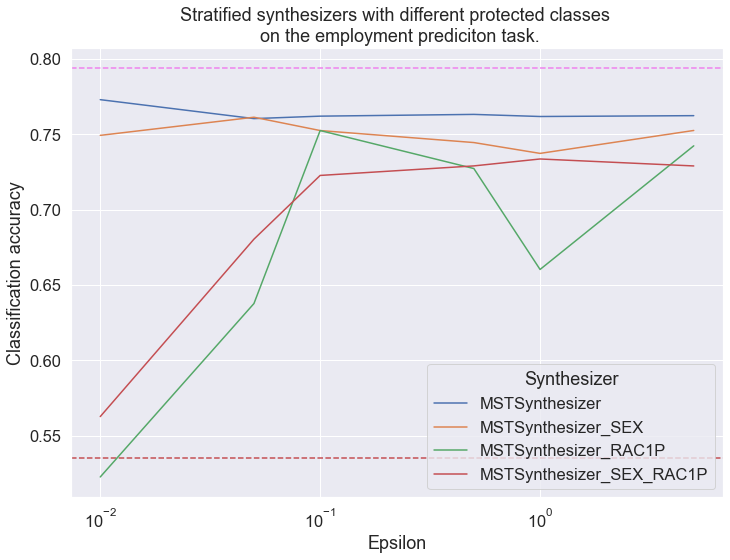

In [105]:
plot_performance_synths(performance_df, overall_accuracy=accuracy_overall)

In [133]:
fit_vanilla_model(AIMSynthesizer, 0.1, df)

10
Initial Sigma 708.3816817807548


KeyboardInterrupt: 

In [132]:
stratified_synth_aim = ParallelStratifiedSynthesizer(AIMSynthesizer, epsilon=0.1)
stratified_synth_aim.fit(df, strata_cols=['SEX'], categorical_columns=df.columns)

Fitting synthesizer on strata with size 101805
Fitting synthesizer on strata with size 95162
10
10
Initial Sigma 708.3816817807548
Initial Sigma 708.3816817807548


In [114]:
with open('models/GEMSynthesizer_epsilon_0.1.pkl', "rb") as file:
    model = dill.load(file)

In [128]:
stratified_synth.stratified_dataset.force_data_categorical_to_numeric(df).astype(float).describe()

,AGEP,SCHL,MAR,DIS,ESP,MIL,DREM,SEX,RAC1P,ESR
count,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000
mean,1.687328,2.834246,3.042713,1.865262,0.543330,3.183203,1.851990,1.516863,2.185625,0.464387
std,1.234446,1.246443,1.867062,0.341445,1.587463,1.547406,0.471425,0.499717,2.341672,0.498731
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000,2.000000,0.000000,4.000000,2.000000,1.000000,1.000000,0.000000
50%,2.000000,3.000000,3.000000,2.000000,0.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,3.000000,4.000000,5.000000,2.000000,0.000000,4.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,4.000000,5.000000,2.000000,8.000000,4.000000,2.000000,2.000000,9.000000,1.000000


In [134]:
stratified_synth_aim.sample(2000).describe()

,AGEP,SCHL,MAR,DIS,ESP,MIL,DREM,SEX,RAC1P,ESR
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,1.679340,2.824912,2.042021,0.863432,0.532766,3.170085,1.852426,0.483242,1.172086,0.465733
std,1.232984,1.252968,1.872362,0.343477,1.567565,1.554832,0.474297,0.499844,2.316845,0.498949
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,1.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,2.000000,1.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000
75%,3.000000,4.000000,4.000000,1.000000,0.000000,4.000000,2.000000,1.000000,1.000000,1.000000
max,4.000000,4.000000,4.000000,1.000000,8.000000,4.000000,2.000000,1.000000,8.000000,1.000000
